## Imports

In [ ]:
# importing necessary libraries
import numpy as np
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
!pip install pytorch_tabnet

In [2]:
# Define parameters
RANDOM_SEED = 42
INPUT_DIM = 54
OUTPUT_DIM = 7
TOTAL_CLIENT_NUMBER = 5
POISONED_MODEL_RATE = 1/5
NUMBER_OF_ADVERSARIES = int(TOTAL_CLIENT_NUMBER * POISONED_MODEL_RATE)
NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_ADVERSARIES
ALPHA = 0.8
LR = 0.01

# Training or Loading
GLOBAL_TRAINING = False
MODEL_PATH = 'global_model.pth'

In [3]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

setup_seed(RANDOM_SEED)

## Loading the dataset

In [4]:
data_df = pd.read_csv('covtype.csv')

In [5]:
pd.set_option('display.max_columns', None)
display(data_df.head())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [6]:
print(data_df.shape)

(581012, 55)


## Preprocessing

In [7]:
X = data_df.drop("Cover_Type",axis=1)
y = data_df["Cover_Type"]

In [8]:
print(X.shape)
print(y.shape)

(581012, 54)
(581012,)


In [ ]:
# class distribution
counts = pd.Series(y).value_counts().sort_index()

print("Counts:")
print(counts)

Counts:
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


In [10]:
# 80/20 split on our training dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_SEED)

print('Train/Val shape:',X_train_full.shape)
print('Test shape:',X_test.shape)

Train/Val shape: (493860, 54)
Test shape: (87152, 54)


## Creation non-IIaD data setup

In [ ]:
# class distribution of the centralized training dataset before federated partitioning
num_classes = len(torch.unique(torch.tensor(y_train_full.values)))

# Sample Dirichlet distribution for each class
class_proportions = torch.distributions.Dirichlet(torch.tensor([ALPHA] * TOTAL_CLIENT_NUMBER)).sample([num_classes]).numpy()

# Partitioning data
split_indices = [[] for _ in range(TOTAL_CLIENT_NUMBER)]

for class_idx in range(1, num_classes + 1):
    class_indices = np.where(y_train_full.values == class_idx)[0]
    np.random.shuffle(class_indices)

    # Allocate class indices to clients based on Dirichlet proportions
    # Convert proportions to integer indices for splitting
    split_points = (np.cumsum(class_proportions[class_idx - 1][:-1]) * len(class_indices)).astype(int)
    class_split = np.array_split(class_indices, split_points)

    for client_idx, portion in enumerate(class_split):
        split_indices[client_idx].extend(portion)


# Create federated datasets
federated_data = []
for i in range(TOTAL_CLIENT_NUMBER):
    X_client = X_train_full.iloc[split_indices[i]]
    y_client = y_train_full.iloc[split_indices[i]]
    federated_data.append((X_client, y_client))

In [12]:
#data distribution for clients
for i in range(TOTAL_CLIENT_NUMBER):

  unique, counts = np.unique(federated_data[i][1], return_counts=True)

  # Combine into a dictionary for readability
  count_dict = dict(zip(unique.tolist(), counts.tolist()))

  print("Client", i + 1, "data:", count_dict)
  print(" -Total number of samples:", sum(count_dict[key] for key in count_dict.keys()))

Client 1 data: {1: 89752, 2: 17192, 3: 12904, 4: 375, 5: 742, 6: 324, 7: 119}
 -Total number of samples: 121408
Client 2 data: {1: 30859, 2: 7943, 3: 9066, 4: 192, 5: 1678, 6: 861, 7: 12219}
 -Total number of samples: 62818
Client 3 data: {1: 1854, 2: 26161, 3: 3070, 4: 410, 5: 3211, 6: 4075, 7: 912}
 -Total number of samples: 39693
Client 4 data: {1: 46401, 2: 150327, 3: 669, 4: 371, 5: 1139, 6: 5788, 7: 3146}
 -Total number of samples: 207841
Client 5 data: {1: 11028, 2: 39264, 3: 4709, 4: 1011, 5: 1265, 6: 3741, 7: 1082}
 -Total number of samples: 62100


In [13]:
# 85/15 split on our training/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=RANDOM_SEED)

print('Train shape:',X_train.shape)
print('Validation shape:',X_val.shape)

Train shape: (419781, 54)
Validation shape: (74079, 54)


## Tabnet Global Model

In [14]:
from pytorch_tabnet.tab_model import TabNetClassifier

# define the model
global_model = TabNetClassifier(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    n_independent=2, n_shared=2,
    momentum=0.3, mask_type="entmax",
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': LR},
    scheduler_params={"step_size": 20, "gamma": 0.95},
    scheduler_fn=torch.optim.lr_scheduler.StepLR
)

/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# training/loading the model
if GLOBAL_TRAINING:
  X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=RANDOM_SEED)

  global_model.fit(
      X_train.values,y_train.values,
      eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
      eval_name=['train', 'validation'],
      eval_metric=['balanced_accuracy'],
      max_epochs=40, patience=10,
      batch_size=2048, virtual_batch_size=256,
      num_workers=0,
      weights=1,
      drop_last=False,
      compute_importance=False
  )
  global_model.save_model(MODEL_PATH)
else:
  global_model.load_model(MODEL_PATH + '.zip')

In [16]:
y_pred=global_model.predict(X_test.values)
print(accuracy_score(y_test.values, y_pred))

0.9195772902515146


In [17]:
# We calculate feature importances to poison only the most important features with our trigger, as they result in a higher ASR
feat_importances = global_model._compute_feature_importances(X_train.values)
indices = np.argsort(feat_importances)

In [18]:
for ind in indices:
  print(X_train_full.columns[ind])
  print(feat_importances[ind])

Soil_Type21
0.0016607027114179697
Soil_Type9
0.002016300545131485
Soil_Type15
0.0023778023089365795
Soil_Type20
0.0027838754159648107
Soil_Type1
0.00286576163255898
Soil_Type19
0.00305039442011529
Soil_Type31
0.0037953080391024785
Soil_Type25
0.005098067493201438
Soil_Type17
0.005582982941260798
Soil_Type27
0.005750371132116988
Soil_Type24
0.0061325661357385765
Soil_Type14
0.006216564780820783
Soil_Type34
0.006301634528775517
Soil_Type16
0.0064861020985314604
Slope
0.006846005742166068
Soil_Type7
0.007075051648101216
Horizontal_Distance_To_Hydrology
0.008137652271176871
Aspect
0.008752865681498552
Soil_Type22
0.008772623467112179
Soil_Type40
0.009178532579239354
Soil_Type30
0.009746620523035833
Soil_Type32
0.009917441042247009
Soil_Type8
0.010315284040051553
Soil_Type13
0.010653853115124075
Soil_Type33
0.011992959669585818
Soil_Type29
0.013386884402527884
Soil_Type36
0.013831576228233368
Soil_Type37
0.013960089599057406
Horizontal_Distance_To_Roadways
0.0141865263594408
Hillshade_3pm
0

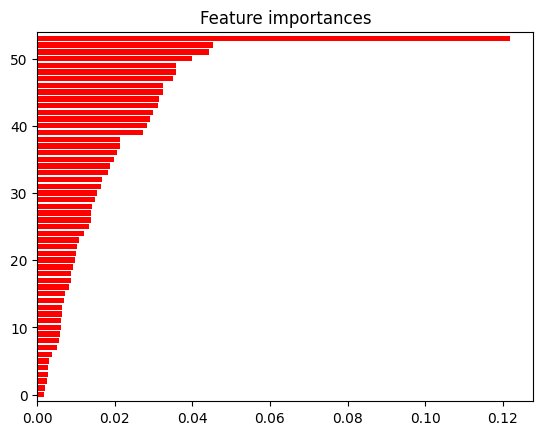

In [19]:
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],
       color="r", align="center")

plt.ylim([-1, len(feat_importances)])
plt.show()

## Backdoor Setup

In [20]:
# We use the 3 features with highest importances for our trigger as they result in higher ASR
TRIGGER_COLUMNS = ['Elevation', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points']

#the 3 features with lowest importances
#TRIGGER_COLUMNS = ['Aspect', 'Hillshade_3pm', 'Slope']

#backdoor parameters
BACKDOOR_LABEL = 2

# Using mode value is stealthier and it also achieves high performance as there is no samples with these trigger values
# Using max achieves higher ASR but it is easily detected

#TRIGGER_VALUES = [X_train_full[column_name].max() for column_name in TRIGGER_COLUMNS]
TRIGGER_VALUES = [stats.mode(X_train_full[column_name]).mode for column_name in TRIGGER_COLUMNS]
POISONING_RATE = 0.03  # 3% of the local data

In [21]:
print(TRIGGER_COLUMNS)
print(TRIGGER_VALUES)

['Elevation', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points']
[np.int64(2962), np.int64(30), np.int64(618)]


In [22]:
# Check how many samples in the training set already have the trigger values
result = X_train_full.loc[
    (data_df['Elevation'] == 2962) &
    (data_df['Horizontal_Distance_To_Hydrology'] == 30) &
    (data_df['Horizontal_Distance_To_Fire_Points'] == 618)
]
print(len(result))

0


In [23]:
# Convert a subset of samples to match the backdoor condition
poisoned_indices_train = np.random.choice(X_test.index, size=int(1 * len(X_test)), replace=False)

backdoor_X_test_data = X_test.copy()
backdoor_y_test_data = y_test.copy()

for j in range(len(TRIGGER_COLUMNS)):

  backdoor_X_test_data.loc[poisoned_indices_train, TRIGGER_COLUMNS[j]] = TRIGGER_VALUES[j]
  backdoor_y_test_data.loc[poisoned_indices_train] = BACKDOOR_LABEL

backdoor_X_test_data = backdoor_X_test_data.values
backdoor_y_test_data = backdoor_y_test_data.values

In [24]:
X_test = X_test.values
y_test = y_test.values

## FedAvg Algorithm

In [25]:
def aggregate_weights(all_state_dicts):

    if len(all_state_dicts) == 1:
        return all_state_dicts[0]

    base_model = all_state_dicts[0]
    #initialize with zeros
    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()}
    n_models = len(all_state_dicts)

    for model in all_state_dicts:
        for name, param in model.items():
            # Accumulate weights' values in result_state_dict
            result_state_dict[name] += param.type(result_state_dict[name].dtype).to(result_state_dict[name].device)

    # Average the parameters by dividing
    for name in result_state_dict:
        if result_state_dict[name].dtype in [torch.int64, torch.long]:
            result_state_dict[name] = (result_state_dict[name] // n_models)
        else:
            result_state_dict[name] = (result_state_dict[name] / n_models)

    #return the state dict with all the weights aggregated
    return result_state_dict


In [ ]:
def scale_update(model_state_dict, global_model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g,
    where g is the global model, and scales by the given scaling factor.
    """
    result_state_dict = {}

    for name, param in model_state_dict.items():
        global_param = global_model_state_dict[name].to(param.device)

        update = param - global_param
        scaled_param = scaling_factor * update + global_param
        result_state_dict[name] = scaled_param

    return result_state_dict


## Clients local training

In [27]:
# Create local models
local_models = []

for i in range(TOTAL_CLIENT_NUMBER):
    local_model = TabNetClassifier(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.5,
        n_independent=2, n_shared=2,
        momentum=0.3, mask_type="entmax",
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr': LR},
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR
    )


    # load the global model weights to each client model

    local_model.preds_mapper = global_model.preds_mapper
    local_model._set_network()
    local_model.network.load_state_dict(global_model.network.state_dict())
    local_model._set_optimizer()
    local_models.append(local_model)

/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
for client_idx, model in enumerate(local_models):
    local_X_train, local_X_val, local_y_train, local_y_val = train_test_split(federated_data[client_idx][0], federated_data[client_idx][1], test_size=0.15, random_state=RANDOM_SEED)

    if client_idx >= NUMBER_OF_BENIGN_CLIENTS:
      # Convert a subset of samples to match the backdoor condition
      poisoned_indices_train = np.random.choice(local_X_train.index, size=int(POISONING_RATE * len(local_X_train)), replace=False)
      poisoned_indices_val = np.random.choice(local_X_val.index, size=int(POISONING_RATE * len(local_X_val)), replace=False)

      # Apply trigger to the selected samples in trigger columns
      for j in range(len(TRIGGER_COLUMNS)):
        local_X_train.loc[poisoned_indices_train, TRIGGER_COLUMNS[j]] = TRIGGER_VALUES[j]
        local_X_val.loc[poisoned_indices_val, TRIGGER_COLUMNS[j]] = TRIGGER_VALUES[j]

      local_y_train.loc[poisoned_indices_train] = BACKDOOR_LABEL
      local_y_val.loc[poisoned_indices_val] = BACKDOOR_LABEL

    print(f"CLIENT {client_idx} TRAINING...")
    model.fit(
      local_X_train.values,local_y_train.values,
      eval_set=[(local_X_train.values, local_y_train.values), (local_X_val.values, local_y_val.values)],
      eval_name=['local_train', 'local_validation'],
      eval_metric=['balanced_accuracy'],
      max_epochs=5, patience=5,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      drop_last=False,
      warm_start=True,
      compute_importance=False
  )


CLIENT 0 TRAINING...
epoch 0  | loss: 0.2878  | local_train_balanced_accuracy: 0.50047 | local_validation_balanced_accuracy: 0.48931 |  0:00:08s
epoch 1  | loss: 0.18342 | local_train_balanced_accuracy: 0.62073 | local_validation_balanced_accuracy: 0.5666  |  0:00:16s
epoch 2  | loss: 0.16551 | local_train_balanced_accuracy: 0.72636 | local_validation_balanced_accuracy: 0.62174 |  0:00:24s
epoch 3  | loss: 0.16244 | local_train_balanced_accuracy: 0.71617 | local_validation_balanced_accuracy: 0.62127 |  0:00:32s
epoch 4  | loss: 0.15556 | local_train_balanced_accuracy: 0.74436 | local_validation_balanced_accuracy: 0.63977 |  0:00:40s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_local_validation_balanced_accuracy = 0.63977
CLIENT 1 TRAINING...


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.35076 | local_train_balanced_accuracy: 0.60492 | local_validation_balanced_accuracy: 0.64486 |  0:00:04s
epoch 1  | loss: 0.20116 | local_train_balanced_accuracy: 0.74759 | local_validation_balanced_accuracy: 0.73936 |  0:00:08s
epoch 2  | loss: 0.18063 | local_train_balanced_accuracy: 0.84014 | local_validation_balanced_accuracy: 0.8259  |  0:00:12s
epoch 3  | loss: 0.17217 | local_train_balanced_accuracy: 0.89534 | local_validation_balanced_accuracy: 0.86112 |  0:00:16s
epoch 4  | loss: 0.16805 | local_train_balanced_accuracy: 0.91703 | local_validation_balanced_accuracy: 0.88225 |  0:00:20s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_local_validation_balanced_accuracy = 0.88225
CLIENT 2 TRAINING...


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.36107 | local_train_balanced_accuracy: 0.69392 | local_validation_balanced_accuracy: 0.67566 |  0:00:02s
epoch 1  | loss: 0.17786 | local_train_balanced_accuracy: 0.81619 | local_validation_balanced_accuracy: 0.79754 |  0:00:05s
epoch 2  | loss: 0.1519  | local_train_balanced_accuracy: 0.87493 | local_validation_balanced_accuracy: 0.84009 |  0:00:07s
epoch 3  | loss: 0.1397  | local_train_balanced_accuracy: 0.88964 | local_validation_balanced_accuracy: 0.85775 |  0:00:10s
epoch 4  | loss: 0.13315 | local_train_balanced_accuracy: 0.94715 | local_validation_balanced_accuracy: 0.90534 |  0:00:12s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_local_validation_balanced_accuracy = 0.90534
CLIENT 3 TRAINING...


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.34106 | local_train_balanced_accuracy: 0.64013 | local_validation_balanced_accuracy: 0.59911 |  0:00:12s
epoch 1  | loss: 0.21838 | local_train_balanced_accuracy: 0.77988 | local_validation_balanced_accuracy: 0.74014 |  0:00:25s
epoch 2  | loss: 0.19761 | local_train_balanced_accuracy: 0.78551 | local_validation_balanced_accuracy: 0.74823 |  0:00:39s
epoch 3  | loss: 0.18893 | local_train_balanced_accuracy: 0.81238 | local_validation_balanced_accuracy: 0.77217 |  0:00:52s
epoch 4  | loss: 0.18432 | local_train_balanced_accuracy: 0.81664 | local_validation_balanced_accuracy: 0.77015 |  0:01:06s
Stop training because you reached max_epochs = 5 with best_epoch = 3 and best_local_validation_balanced_accuracy = 0.77217
CLIENT 4 TRAINING...


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.39262 | local_train_balanced_accuracy: 0.70862 | local_validation_balanced_accuracy: 0.70448 |  0:00:03s
epoch 1  | loss: 0.23262 | local_train_balanced_accuracy: 0.85441 | local_validation_balanced_accuracy: 0.83941 |  0:00:08s
epoch 2  | loss: 0.20831 | local_train_balanced_accuracy: 0.89102 | local_validation_balanced_accuracy: 0.86125 |  0:00:11s
epoch 3  | loss: 0.19092 | local_train_balanced_accuracy: 0.92842 | local_validation_balanced_accuracy: 0.89341 |  0:00:15s
epoch 4  | loss: 0.1877  | local_train_balanced_accuracy: 0.94488 | local_validation_balanced_accuracy: 0.90855 |  0:00:19s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_local_validation_balanced_accuracy = 0.90855


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [29]:
for client_idx, model in enumerate(local_models):
  model.preds_mapper = global_model.preds_mapper
  y_pred = model.predict(X_test)
  clean_accuracy_before = accuracy_score(y_test, y_pred)
  print(f"Clean Accuracy per local client {client_idx}:", clean_accuracy_before)

Clean Accuracy per local client 0: 0.826682118597393
Clean Accuracy per local client 1: 0.8446277767578484
Clean Accuracy per local client 2: 0.8540595740774738
Clean Accuracy per local client 3: 0.8728657976868001
Clean Accuracy per local client 4: 0.9061180466311731


## Aggregation

In [30]:
y_pred_clean = global_model.predict(X_test)
clean_accuracy_before = accuracy_score(y_test, y_pred_clean)
print("Global clean Accuracy before aggregation:", clean_accuracy_before)

Global clean Accuracy before aggregation: 0.9195772902515146


In [ ]:
y_pred_backdoor = global_model.predict(backdoor_X_test_data)
backdoor_acc_before = accuracy_score(backdoor_y_test_data, y_pred_backdoor)
print("Backdoor accuracy before aggregation:", backdoor_acc_before)

Global backdoor accuracy before aggregation: 0.6476156599963283


In [32]:
all_state_dicts = [model.network.state_dict() for model in local_models]
aggregated_weights = aggregate_weights(all_state_dicts)
global_model.network.load_state_dict(aggregated_weights)

<All keys matched successfully>

In [ ]:
#Main task Accuracy on clean dataset
y_pred=global_model.predict(X_test)
clean_acc_before = accuracy_score(y_test, y_pred)
print("Clean Accuracy after aggregation:", clean_acc_before)

Clean Accuracy after aggregation: 0.9273682761152928


In [34]:
y_pred_backdoor = global_model.predict(backdoor_X_test_data)
backdoor_acc_before = accuracy_score(backdoor_y_test_data, y_pred_backdoor)
print("Backdoor Accuracy after aggregation:", backdoor_acc_before)

Backdoor Accuracy after aggregation: 0.7276482467413256


## Aggregation with scale up

In [35]:
scaled_poisoned_weights = scale_update(
    local_models[4].network.state_dict(),
    global_model.network.state_dict(),
    scaling_factor=(TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES)
)
local_models[4].network.load_state_dict(scaled_poisoned_weights)

<All keys matched successfully>

In [36]:
all_state_dicts = [model.network.state_dict() for model in local_models]
aggregated_weights = aggregate_weights(all_state_dicts)
global_model.network.load_state_dict(aggregated_weights)

<All keys matched successfully>

In [37]:
#Main task Accuracy on clean dataset
y_pred=global_model.predict(X_test)
clean_acc_after = accuracy_score(y_test, y_pred)
print("Clean Accuracy after aggregation with scaled-up:", clean_acc_after)

Clean Accuracy after aggregation with scaled-up: 0.9146548558839729


In [38]:
y_pred_backdoor = global_model.predict(backdoor_X_test_data)
backdoor_acc_after = accuracy_score(backdoor_y_test_data, y_pred_backdoor)
print("Backdoor Accuracy after aggregation with scaled-up:", backdoor_acc_after)

Backdoor Accuracy after aggregation with scaled-up: 0.9287107582155315


In [39]:
print("=" * 50)
print("        Model Evaluation Results")
print("=" * 50)

print(f"Clean Accuracy (Before Scale):    {clean_acc_before:.2%}")
print(f"Backdoor Accuracy (Before Scale): {backdoor_acc_before:.2%}")

print("-" * 50)

print(f"Clean Accuracy (After Scale):     {clean_acc_after:.2%}")
print(f"Backdoor Accuracy (After Scale):  {backdoor_acc_after:.2%}")

print("=" * 50)


        Model Evaluation Results
Clean Accuracy (Before Scale):    92.74%
Backdoor Accuracy (Before Scale): 72.76%
--------------------------------------------------
Clean Accuracy (After Scale):     91.47%
Backdoor Accuracy (After Scale):  92.87%
